# Varying diameter

In this notebook we will try to create a scaling law to account for a varying propeller diameter as well as a varying number of blade and a varying altitude. Twist law should also vary but for now it will be left as is.

In [1]:
# This file is part of FAST-OAD_CS23-HE : A framework for rapid Overall Aircraft Design of Hybrid
# Electric Aircraft.
# Copyright (C) 2022 ISAE-SUPAERO

# Import pyVPLM modules/functions
from pyvplm.core.definition import PositiveParameter, PositiveParameterSet
from pyvplm.addon.variablepowerlaw import buckingham_theorem

from stdatm import Atmosphere

altitude_min, altitude_max = 0, 30000 # In feet
rho_min = Atmosphere(altitude_max, altitude_in_feet=True).density
rho_max = Atmosphere(altitude_min, altitude_in_feet=True).density

# Declare physical variables and set (limits have no impact since DOE is not constructed)
t = PositiveParameter("t", [0.01, 46172.16929583475], "N", "trust")
rho = PositiveParameter("rho", [rho_min, rho_max], "kg/m^3", "air density")
n_rot = PositiveParameter("n_rot", [16.66, 83.33], "Hz", "rotational speed")
d = PositiveParameter("d", [0.75, 3.0], "m", "propeller diameter")
pitch = PositiveParameter("pitch", [0.087, 1.0472], "rad", "propeller pitch @0.75 of the radius")
PITCH_REF = PositiveParameter("PITCH_REF", [0.087], "rad", "propeller reference pitch @0.75 of the radius")
v = PositiveParameter("v", [15.0, 191.37333333333333], "m/s", "air speed")
c_mid_ratio = PositiveParameter("c_mid_ratio", [1.1, 5.0], "", "chord at the mid point as a ratio of root chord")
c_mid_radius_ratio = PositiveParameter("c_mid_radius_ratio", [0.4, 0.8], "", "position of the mid point chord as a ratio of radius")
parameter_set = PositiveParameterSet(t, rho, n_rot, d, pitch, PITCH_REF, v, c_mid_ratio, c_mid_radius_ratio)

# Define d and lambda_wind to be first elected as repetitive set
parameter_set.first("n_rot", "d", "rho")
# parameter_set.latex_render()

# Calculate pi parameters with first repetitive set found in parameters' order
pi_set, _ = buckingham_theorem(parameter_set, False)
# pi_set.latex_render()

C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\pyvplm\core\definition.py:125: UserWarning: accessing private attribute value
  warnings.warn("accessing private attribute value")


We'll adjust slightly the defined set here to take something similar to the previous notebook, that is $\pi_2 = \frac{picth}{PITCH_{REF}}$ and $\pi_3 = n_{blade}$

n_rot: n_rot in [16.66,83.33]hertz, rotational speed
d: d in [0.75,3.0]meter, propeller diameter
rho: rho in [0.45830910954018267,1.2249908312368587]kilogram / meter ** 3, air density
pitch: pitch in [0.087,1.0472]radian, propeller pitch @0.75 of the radius
PITCH_REF: PITCH_REF=0.087radian, propeller reference pitch @0.75 of the radius
v: v in [15.0,191.37333333333333]meter / second, air speed
c_mid_ratio: c_mid_ratio in [1.1,5.0], chord at the mid point as a ratio of root chord
c_mid_radius_ratio: c_mid_radius_ratio in [0.4,0.8], position of the mid point chord as a ratio of radius



Set reduction factor (from feasible to optimal) is 99.97%



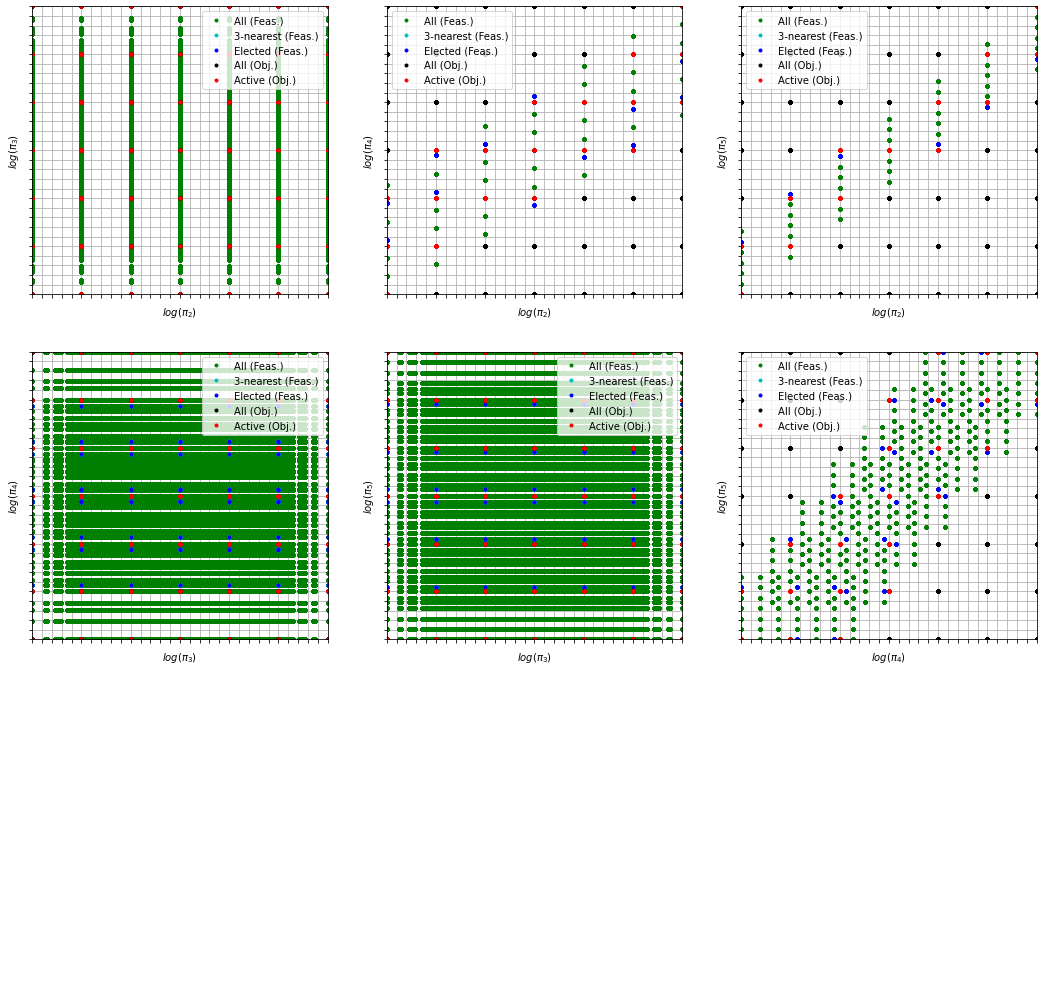

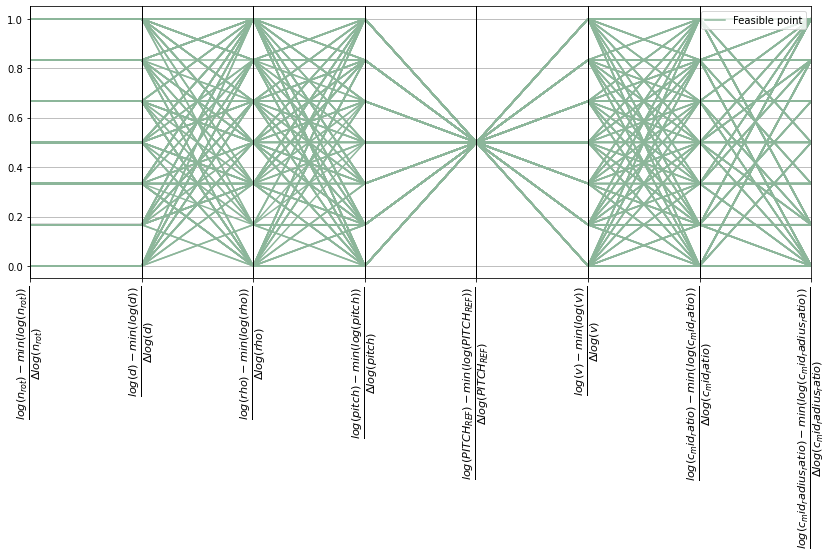

In [2]:
# Import pyVPLM modules/functions
from pyvplm.core.definition import Constraint, ConstraintSet
from pyvplm.addon.pixdoe import create_const_doe
from pyvplm.addon.variablepowerlaw import (
    declare_func_x_to_pi,
    reduce_parameter_set,
    declare_constraints,
)
from pyvplm.addon.comsoladdon import save_file

reduced_parameter_set, reduced_pi_set = reduce_parameter_set(
    parameter_set, pi_set, elected_output="t"
)
# reduced_pi_set.latex_render()
# reduced_parameter_set.latex_render()

print(reduced_parameter_set)

constraint1 = Constraint("n_rot**2*d**2/4 + v**2<=340.0**2")
# constraint3 = Constraint("n_blade%1<=0.05") # Somewhat of a check to keep the number of blade an integer
parameters_constraints = declare_constraints(reduced_parameter_set, ConstraintSet(constraint1))
# Not used since veything is post treated afterwards

# Save function to translate x parameters to pi parameters
func_x_to_pi = declare_func_x_to_pi(reduced_parameter_set, reduced_pi_set)

results = create_const_doe(
    reduced_parameter_set,
    reduced_pi_set,
    func_x_to_pi,
    whished_size=150,
#     parameters_constraints=parameters_constraints,
)
doeX = results[0]

In [3]:
import numpy as np
import copy

from fastga_he.models.propulsion.components.propulsor.propeller.components.performance_point import _ComputePropellerPointPerformance

n_rot_val = np.array(doeX[:, 0])
D_val = np.array(doeX[:, 1])
RHO_val = np.array(doeX[:, 2])
pitch_val = np.array(doeX[:, 3])
v_val = np.array(doeX[:, 5])

# Finding associated altitudes
altitude = np.zeros_like(RHO_val)
altitude_finder = _ComputePropellerPointPerformance()

for idx, rho in enumerate(RHO_val):
    altitude[idx] = altitude_finder.find_altitude(rho)

atm = Atmosphere(altitude, altitude_in_feet=False)
atm.true_airspeed = np.sqrt(n_rot_val ** 2.0 * (D_val / 2.0) ** 2.0 + v_val ** 2.0)

proper_idx_1 = np.where(atm.mach <= 0.95)[0]
    
aoa_75 = pitch_val - np.arctan2(v_val, 0.75 * n_rot_val * (D_val / 2.0) * 2.0 * np.pi)

proper_index_2 = np.where(abs(aoa_75 - 0.05) < 0.22)[0]

proper_index = np.intersect1d(proper_idx_1, proper_index_2)

new_doeX = doeX[proper_index, :]

possible_blade_number = np.array([2,3,4,5,6,7,8])
# possible_blade_number = np.array([5])
data_len = new_doeX.shape[0]

n_blade_array = np.full(data_len, possible_blade_number[0])
temp_doeX = np.c_[new_doeX, n_blade_array]

new_doeX = copy.deepcopy(temp_doeX)
new_altitude = copy.deepcopy(altitude)

for n_blade in possible_blade_number[1:]:
    n_blade_array = np.full(data_len, n_blade)
    temp_doeX[:,-1] = n_blade_array
    new_doeX = np.r_[new_doeX, temp_doeX]
    new_altitude = np.r_[new_altitude, altitude]

n_rot_val = np.array(new_doeX[:, 0])
D_val = np.array(new_doeX[:, 1])
RHO_val = np.array(new_doeX[:, 2])
pitch_val = np.array(new_doeX[:, 3])
PITCH_REF_val = np.array(new_doeX[:, 4])
v_val = np.array(new_doeX[:, 5])
n_blade_val = np.array(new_doeX[:, 6])
c_mid_ratio_val = np.array(new_doeX[:, 7])
c_mid_radius_ratio_val = np.array(new_doeX[:, 8])

In [4]:
import os.path as pth
from fastga_he.models.propulsion.components.propulsor.propeller.components.performance_point_d_var import (
    ComputePropellerPointPerformanceDVar,
)
from fastga.command.api import generate_block_analysis

# Define relative path
DATA_FOLDER_PATH = "data"
DATA_FILE = pth.join(DATA_FOLDER_PATH, "input_tbm900_d_var.xml")

# Define the wing primary geometry parameters name as a list
var_inputs = [
    "data:geometry:propeller:average_rpm",
    "data:geometry:propeller:diameter",
    "data:geometry:propeller:blades_number",
    "data:geometry:propeller:mid_chord_ratio",
    "data:geometry:propeller:mid_chord_radius_ratio",
    "data:aerodynamics:propeller:point_performance:rho",
    "data:aerodynamics:propeller:point_performance:twist_75",
    "data:aerodynamics:propeller:point_performance:twist_75_ref",
    "data:aerodynamics:propeller:point_performance:speed",
]

# Declare function
compute_propeller = generate_block_analysis(
    ComputePropellerPointPerformanceDVar(),
    var_inputs,
    str(DATA_FILE),
    overwrite=False,
)

2 Explicit Output(s) in 'system.propeller_point_perf_aero_conditions'

varname                               val       
------------------------------------  ----------
data:aerodynamics:propeller:mach      [0.]      
data:aerodynamics:propeller:reynolds  [1000000.]


0 Implicit Output(s) in 'system.propeller_point_perf_aero_conditions'




In [5]:
thrust_array = np.zeros_like(n_rot_val)
power_array = np.zeros_like(n_rot_val)
eta_array = np.zeros_like(n_rot_val)
sigma_array = np.zeros_like(n_rot_val)
AF_array = np.zeros_like(n_rot_val)
lambda_array = np.zeros_like(n_rot_val)

for idx, n_rot_it in enumerate(n_rot_val):
    inputs_dict = {
        "data:geometry:propeller:average_rpm": (n_rot_it, "rps"),
        "data:geometry:propeller:diameter": (D_val[idx], "m"),
        "data:geometry:propeller:blades_number": (n_blade_val[idx], None),
        "data:geometry:propeller:mid_chord_ratio": (c_mid_ratio_val[idx], None),
        "data:geometry:propeller:mid_chord_radius_ratio": (c_mid_radius_ratio_val[idx], None),
        "data:aerodynamics:propeller:point_performance:rho": (RHO_val[idx], "kg/m**3"),
        "data:aerodynamics:propeller:point_performance:twist_75": (pitch_val[idx], "rad"),
        "data:aerodynamics:propeller:point_performance:twist_75_ref": (PITCH_REF_val[idx], "rad"),
        "data:aerodynamics:propeller:point_performance:speed": (v_val[idx], "m/s"),
    }
    output_dict = compute_propeller(inputs_dict)
    thrust = output_dict["data:aerodynamics:propeller:point_performance:thrust"][0][0]
    power = output_dict["data:aerodynamics:propeller:point_performance:power"][0][0]
    eta = output_dict["data:aerodynamics:propeller:point_performance:efficiency"][0][0]
    sigma = output_dict["data:geometry:propeller:solidity_ratio"][0][0]
    AF = output_dict["data:geometry:propeller:activity_factor"][0][0]
    aspect_ratio = output_dict["data:geometry:propeller:aspect_ratio"][0][0]
    thrust_array[idx] = thrust
    power_array[idx] = power
    eta_array[idx] = eta
    sigma_array[idx] = sigma
    AF_array[idx] = AF
    lambda_array[idx] = aspect_ratio

C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvem

In [6]:
from functools import reduce

# proper_result_idx = np.where(abs(eta_array - 0.5) < 0.5)[0]
proper_result_idx_1 = np.where(eta_array!=np.nan)
proper_result_idx_2 = np.where(thrust_array>0.0)
proper_result_idx_3 = np.where(power_array>0.0)

proper_result_idx = reduce(
    np.intersect1d, 
    (
        proper_result_idx_1, 
        proper_result_idx_2, 
        proper_result_idx_3, 
    )
)

thrust_array = thrust_array[proper_result_idx]
power_array = power_array[proper_result_idx]
eta_array = eta_array[proper_result_idx]
sigma_array = sigma_array[proper_result_idx]
AF_array = AF_array[proper_result_idx]
lambda_array = lambda_array[proper_result_idx]

n_rot_val = n_rot_val[proper_result_idx]
D_val = D_val[proper_result_idx]
n_blade_val = n_blade_val[proper_result_idx]
RHO_val = RHO_val[proper_result_idx]
pitch_val = pitch_val[proper_result_idx]
PITCH_REF_val = PITCH_REF_val[proper_result_idx]
v_val = v_val[proper_result_idx]

altitude = new_altitude[proper_result_idx]

ct_array = thrust_array / (RHO_val * n_rot_val ** 2 * D_val ** 4)
cp_array = power_array / (RHO_val * n_rot_val ** 3 * D_val ** 5)

# Trying $\eta$ as a function of Ct and J

C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Elected model for regression is n°40:


<IPython.core.display.Latex object>

<Figure size 432x288 with 0 Axes>

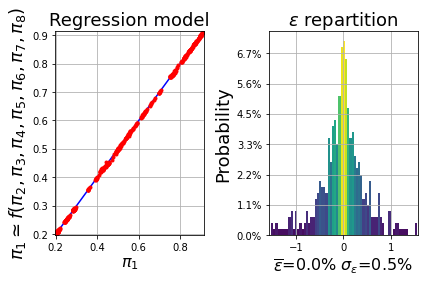

In [8]:
# Import pyVPLM modules/functions
from pyvplm.addon.variablepowerlaw import regression_models, perform_regression

import pandas as pd

atm = Atmosphere(altitude, altitude_in_feet=False)

pi1 = eta_array
pi2 = ct_array
pi3 = v_val / (n_rot_val * D_val)
pi4 = (v_val**2.0 + n_rot_val ** 2.0 * (D_val / 2.0) ** 2.0 ) / atm.speed_of_sound ** 2.0
pi5 = v_val * D_val / atm.kinematic_viscosity
pi6 = sigma_array
pi7 = AF_array
pi8 = lambda_array
doe_eta = np.c_[pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8]
doe_eta = pd.DataFrame(doe_eta, columns=["pi1", "pi2", "pi3", "pi4", "pi5", "pi6", "pi7", "pi8"])

# Fit with 3rd order power-law model the obtained Pi DOE
model = regression_models(
    doe_eta.values, elected_pi0="pi1", order=3, log_space=True, ymax_axis=10, test_mode=True
)
perform_regression(doe_eta.values, model, choosen_model=40)

# Trying Ct as a function of J, twist and other parameters

C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Elected model for regression is n°40:


<IPython.core.display.Latex object>

<Figure size 432x288 with 0 Axes>

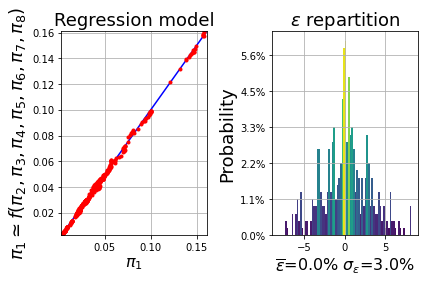

In [13]:
atm = Atmosphere(altitude, altitude_in_feet=False)

pi1 = ct_array
pi2 = v_val / (n_rot_val * D_val)
pi3 = (v_val**2.0 + n_rot_val ** 2.0 * (D_val / 2.0) ** 2.0) / atm.speed_of_sound ** 2.0
pi4 = v_val * D_val / atm.kinematic_viscosity
pi5 = sigma_array
pi6 = pitch_val / PITCH_REF_val
pi7 = AF_array
pi8 = lambda_array
doe_ct = np.c_[pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8]
doe_ct = pd.DataFrame(doe_ct, columns=["pi1", "pi2", "pi3", "pi4", "pi5", "pi6", "pi7", "pi8"])

# Fit with 3rd order power-law model the obtained Pi DOE
model = regression_models(
    doe_ct.values, elected_pi0="pi1", order=3, log_space=True, ymax_axis=10, test_mode=True
)
perform_regression(doe_ct.values, model, choosen_model=40)

# Trying Ct as a function of J, Cp and other parameters

C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Elected model for regression is n°40:


<IPython.core.display.Latex object>

<Figure size 432x288 with 0 Axes>

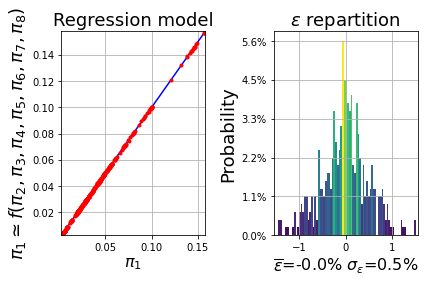

In [10]:
atm = Atmosphere(altitude, altitude_in_feet=False)

pi1 = ct_array
pi2 = v_val / (n_rot_val * D_val)
pi3 = (v_val**2.0 + n_rot_val ** 2.0 * (D_val / 2.0) ** 2.0) / atm.speed_of_sound ** 2.0
pi4 = v_val * D_val / atm.kinematic_viscosity
pi5 = sigma_array
pi6 = cp_array
pi7 = AF_array
pi8 = lambda_array
doe_ct = np.c_[pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8]
doe_ct = pd.DataFrame(doe_ct, columns=["pi1", "pi2", "pi3", "pi4", "pi5", "pi6", "pi7", "pi8"])

# Fit with 3rd order power-law model the obtained Pi DOE
model = regression_models(
    doe_ct.values, elected_pi0="pi1", order=3, log_space=True, ymax_axis=10, test_mode=True
)
perform_regression(doe_ct.values, model, choosen_model=40)

# Trying Cp as a function of J, Ct and other parameters

C:\Users\fl.lutz\Anaconda3\envs\FAST-OAD-CS23-HE-v2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Elected model for regression is n°40:


<IPython.core.display.Latex object>

<Figure size 432x288 with 0 Axes>

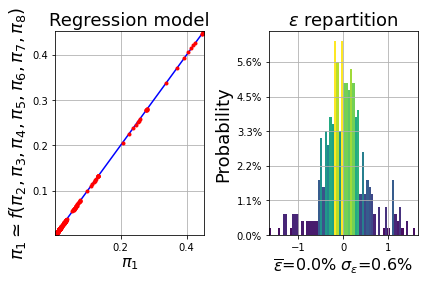

In [12]:
atm = Atmosphere(altitude, altitude_in_feet=False)

pi1 = cp_array
pi2 = v_val / (n_rot_val * D_val)
pi3 = (v_val**2.0 + n_rot_val ** 2.0 * (D_val / 2.0) ** 2.0) / atm.speed_of_sound ** 2.0
pi4 = v_val * D_val / atm.kinematic_viscosity # Somehow reduced the deviation :O
pi5 = sigma_array
pi6 = ct_array
pi7 = AF_array
pi8 = lambda_array
doe_cp = np.c_[pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8]
doe_cp = pd.DataFrame(doe_cp, columns=["pi1", "pi2", "pi3", "pi4", "pi5", "pi6", "pi7", "pi8"])

# Fit with 3rd order power-law model the obtained Pi DOE
model = regression_models(
    doe_cp.values, elected_pi0="pi1", order=3, log_space=True, ymax_axis=10, test_mode=True
)
perform_regression(doe_cp.values, model, choosen_model=40)